In [ ]:
import os
import json
import sys
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline
sns.set(color_codes=True)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
customer_data = pd.read_csv("CustomerData_clean.csv")
complaints_data = pd.read_csv("Complaints_with_OpenAI_Themes.csv")
merged_data = pd.read_csv("CustomerData_Augmented.csv")

# EDA

In [ ]:
# Load cleaned customer data
df = pd.read_csv("CustomerData_clean.csv")
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# 1. Basic Info
print("\nDataset Shape:", df.shape)
print("\nColumn Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())
print("\nSummary Stats:\n", df.describe())


Dataset Shape: (7043, 25)

Column Types:
 customerID                                object
gender                                     int64
SeniorCitizen                              int64
Partner                                    int64
Dependents                                 int64
tenure                                     int64
PhoneService                               int64
MultipleLines                              int64
OnlineSecurity                           float64
OnlineBackup                             float64
DeviceProtection                         float64
TechSupport                              float64
StreamingTV                              float64
StreamingMovies                          float64
PaperlessBilling                           int64
MonthlyCharges                           float64
TotalCharges                             float64
InternetService_Fiber optic                 bool
InternetService_No                          bool
Contract_One year         

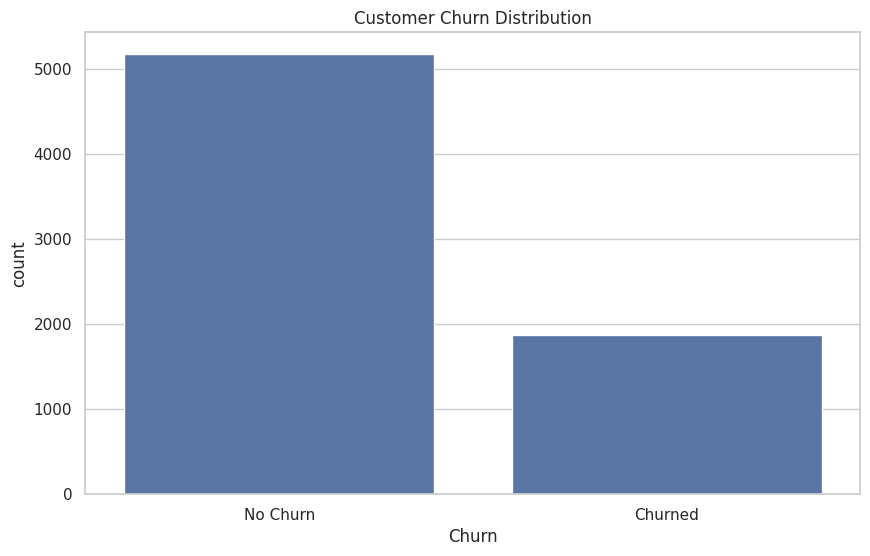


Churn Rate: 26.54%


In [ ]:
# 2. Churn Count & Distribution
sns.countplot(data=df, x='Churn')
plt.title("Customer Churn Distribution")
plt.xticks([0, 1], ['No Churn', 'Churned'])
plt.show()

# % churned
churn_rate = df['Churn'].mean()
print(f"\nChurn Rate: {churn_rate:.2%}")

Understanding the distribution of the target variable (Churn) is critical for this analysis. If the dataset is imbalanced (e.g., significantly more non-churners than churners), we will address this during modeling.

Churn Rate turns out to be 26.54%, leading us to use **SMOTE** to address imbalanced dataset during modeling.

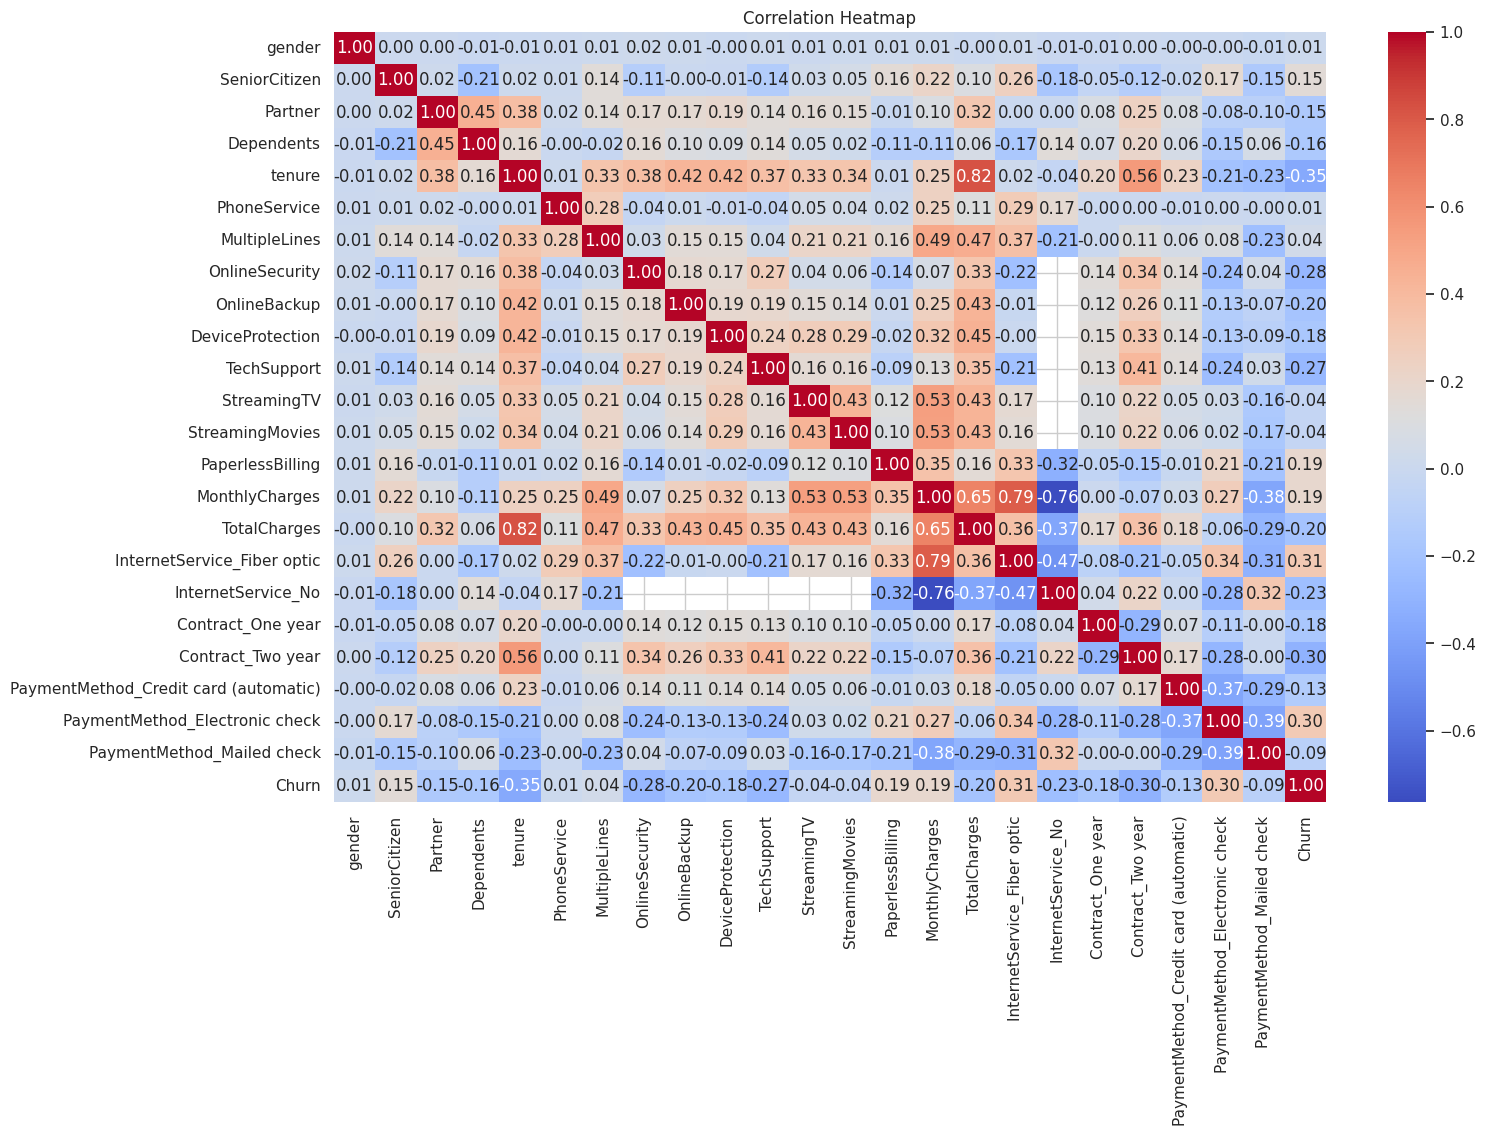

In [ ]:
# 3. Correlation Heatmap
plt.figure(figsize=(16, 10))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

We analyze the correlation between numerical features to identify relationships that may be useful for feature engineering or model development.

Insights:
- **Tenure** is negatively correlated with churn (-0.35), indicating that customers with longer tenure are less likely to churn.
- **Contract two year** is negatively correlated with churn (-0.30), indicating that customers with two-year contracts are less likely to churn compared to those on shorter contracts.
- **Monthly Charges** has a positive correlation with churn (0.19), suggesting that higher charges are associated with higher churn rates.
- **Internet Service Fiber Optic** is positively correlated with churn (0.31), indicating that customers using fiber optic internet are more likely to churn, possibly due to dissatisfaction with the service or pricing.
- **Payment Method Electronic Check** is positively correlated with churn (0.30), indicating that customers paying via electronic checks are more likely to churn, possibly due to dissatisfaction with the payment method or lack of automation.
- **Gender** shows little to no correlation with churn (0.01), suggesting it is not a strong predictor.
- **PhoneService** shows little to no correlation with churn (0.01), suggesting it is not a strong predictor.

These correlations will guide feature selection and engineering in the modeling phase.

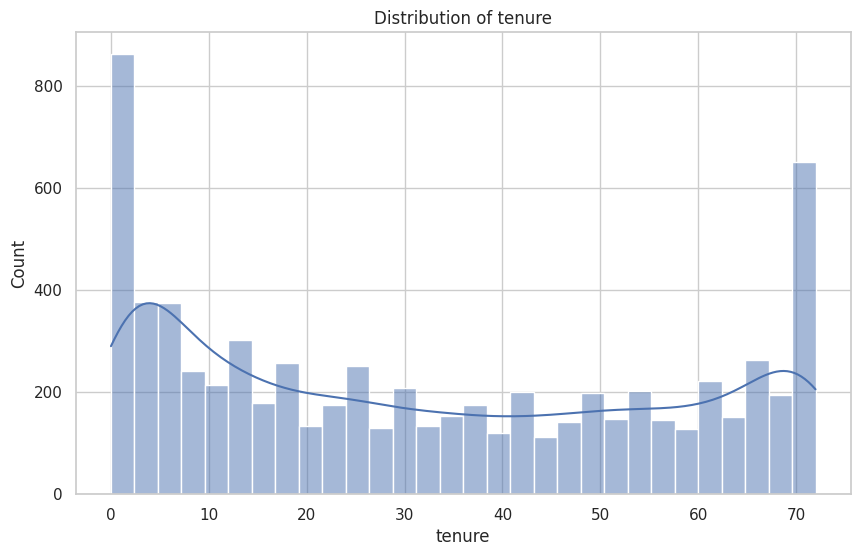

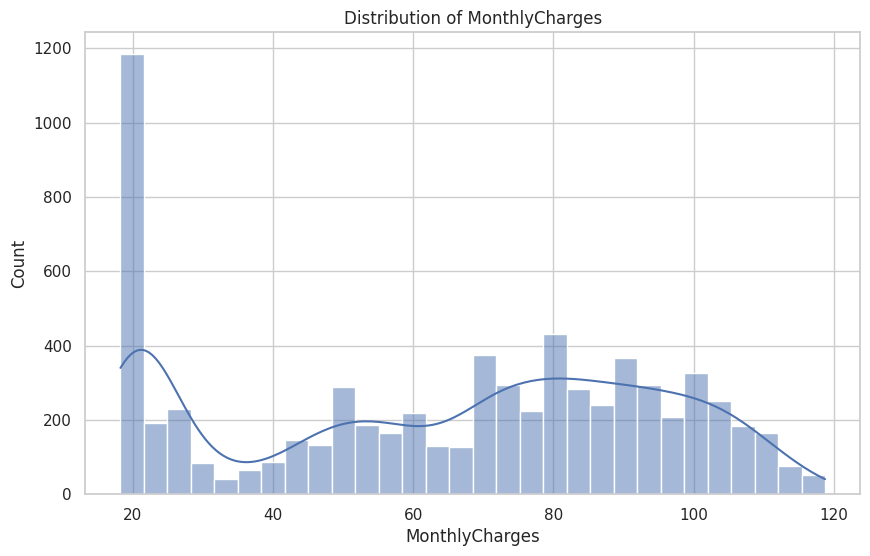

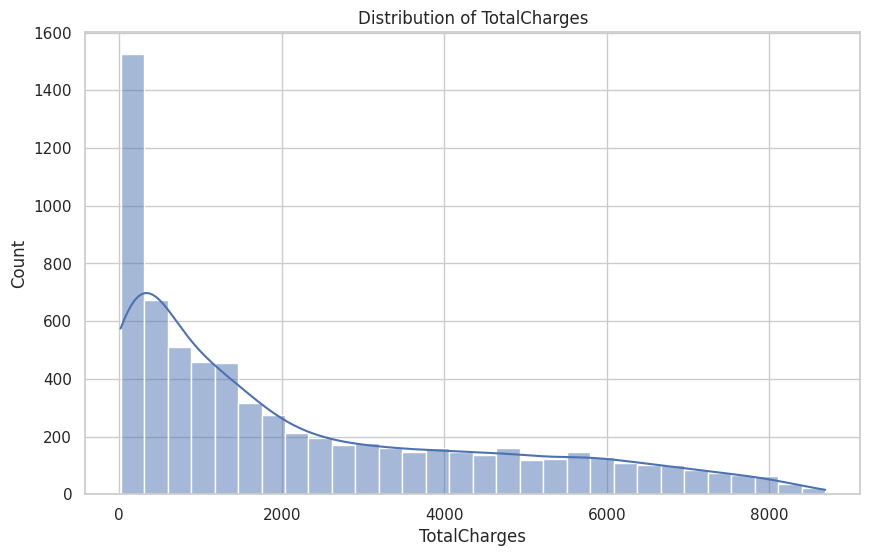

In [ ]:
# 4. Histograms of Numerical Features
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

for col in num_cols:
    sns.histplot(data=df, x=col, kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.show()

The histograms show the distribution of the numerical features: **`Tenure`**, **`MonthlyCharges`**, and **`TotalCharges`**. These visualizations help us understand the spread, central tendency, and shape of the data for each feature.

- **Tenure**: The distribution is bimodal, with many customers having very short tenure (0–1 months) and a significant group with long tenure. Short-tenure customers are more likely to churn, highlighting the need for early retention strategies.

- **MonthlyCharges**: The distribution is approximately uniform, with peaks around 20 and 80. Higher monthly charges are associated with higher churn, suggesting dissatisfaction among high-paying customers.

- **TotalCharges**: The distribution is right-skewed, with most customers having lower total charges. This is influenced by tenure and monthly charges, with higher total charges typically linked to long-tenure, high-paying customers.

<ipython-input-4-0d5e9edf987e>:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_by_group = df.groupby(col)['Churn'].mean().sort_values(ascending=False)
<ipython-input-4-0d5e9edf987e>:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_by_group.values, y=churn_by_group.index, palette='viridis')


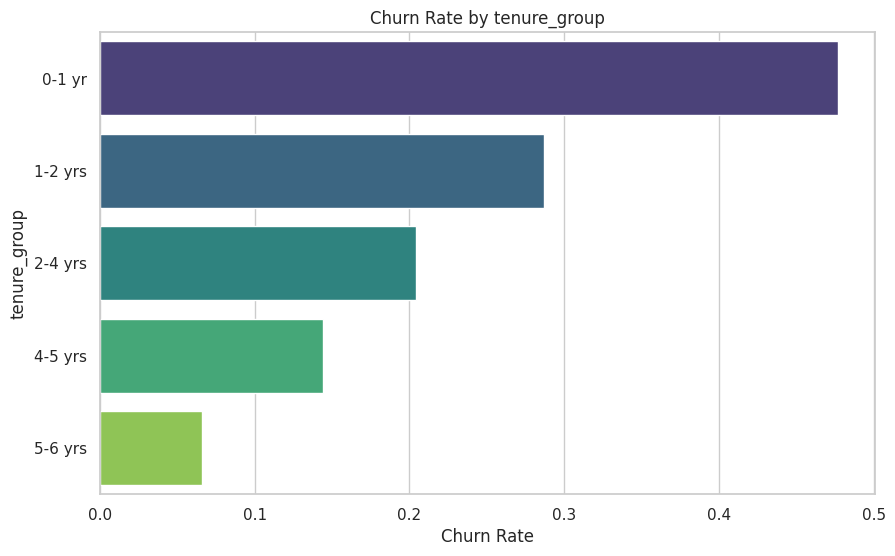

In [ ]:
# 5. Tenure Grouping
df['tenure_group'] = pd.cut(df['tenure'], bins=[0, 12, 24, 48, 60, 72],
                            labels=['0-1 yr', '1-2 yrs', '2-4 yrs', '4-5 yrs', '5-6 yrs'])

plot_churn_rate('tenure_group')

The tenure grouping brings us closer to the correlation between tenure and churn

- Customers with **0–1 year of tenure** have the highest churn rate, indicating that new customers are at the greatest risk of leaving.
- Churn rates decrease steadily as tenure increases, with customers who have been with the company for **5–6 years** having the lowest churn rate.
- This highlights the importance of focusing retention efforts on new customers during their first year to reduce churn.

In [ ]:
# Select churn-related features
selected_features = ["tenure", "TotalCharges", "num_complaints", "InternetService_Fiber optic"]
cdf = merged_data.copy()

if 'customerID' in cdf.columns:
    cdf = cdf.drop(['customerID'], axis=1)

X = cdf[selected_features]
y = cdf["Churn"]

# Impute and scale
imputer = SimpleImputer(strategy="median")
X_imp = imputer.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)

# Cluster using GMM
gmm = GaussianMixture(n_components=8, random_state=42)
cdf["Cluster"] = gmm.fit_predict(X_scaled)

# Calculate churn rate by cluster
cluster_summary = cdf.groupby("Cluster")["Churn"].agg(['count', 'sum'])
cluster_summary["churn_rate"] = cluster_summary["sum"] / cluster_summary["count"]
cluster_summary = cluster_summary.rename(columns={"count": "num_customers", "sum": "num_churned"})

# Find indicative values for the cluster means
M = gmm.means_

M_original = scaler.inverse_transform(M)  # Back to imputed values
M_original = imputer.inverse_transform(M_original)  # Back to original scale with any missing structure

M_original = np.array(M_original)

df_means = pd.DataFrame(M_original, columns=selected_features)
df_means.index.name = "Cluster"

# Generate a summary for the clusters
merged_summary = pd.merge(df_means, cluster_summary, left_index=True, right_index=True)
print(merged_summary)

# Identify extreme churn clusters
high_churn = cluster_summary[cluster_summary["churn_rate"] > 0.7]
low_churn = cluster_summary[cluster_summary["churn_rate"] < 0.15]

print("\nHigh Churn Risk Clusters (>70%):")
print(high_churn)
print("\nLow Churn Risk Clusters (<15%):")
print(low_churn)


           tenure  TotalCharges  num_complaints  InternetService_Fiber optic  \
Cluster                                                                        
0       -1.021611     -0.904207       -0.281635                    -0.885660   
1        0.469461      0.897449        2.527679                     1.129102   
2       -1.057697     -0.758283        2.624552                     1.129102   
3       -0.202386     -0.420691        5.897673                    -0.885660   
4       -1.140938     -0.929638        2.095735                    -0.885660   
5        0.452271      0.000576        2.141715                    -0.885660   
6        0.062893      0.450321       -0.281635                     1.129102   
7        0.623599      0.048497       -0.281635                    -0.885660   

         num_customers  num_churned  churn_rate  
Cluster                                          
0                 1389          325    0.233981  
1                  209          123    0.588517  

*   **Reasoning**: \\
Clustering was chosen to highlight non-linear trends which might not have been immediately evident in the correlation matrix
*   **Key Insights from the Data**: \\
1.  *High Churn Risk Cluster (>70%)*: \\
Cluster 2: This cluster has a very high churn rate of **91.67%**. Customers in this group have high values for num_complaints and InternetService_Fiber optic, indicating that customers with more complaints and who use fiber optic internet tend to churn at a higher rate. \\
2.  *Low Churn Risk Cluster (<15%)*: \\
Cluster 7: This cluster has a very low churn rate of **5.37%**. These customers tend to have lower values for features like num_complaints and InternetService_Fiber optic, making them less likely to churn. \\
Of course, these percentages have to be considered in relation to the lower churn rate observed ub the entire dataset, making the high churn more significant and the lower churn less indicative.

*   **Business Insights**: \\

1.   Customers using fiber-optic internet tend to churn at a higher rate
2.   Tenure is a strong churn protector, even for segments more likely to churn (such as fiber-optic customers)
3.   Lower cost is a moderately strong churn protector, but does not align with all customer segment incentives.

*   **Operational Recommendations**: \\
1.   The most problematic service is **fiber-optic internet**. Even though there is a high cost associated with churn, it is advantageous to maintain the fiber-optic internet service, as it is a associated with higher payments. \\
However, an effort should be made to retain these customers to offset the installation costs. While clients not using fiber-optic internet have been observed to have a strong trend towards higher churn rates when cost are high, the same is not true for customers using fiber-optic internet. This is probably due to the **different customer behaviour** and desires (corporate vs individual consumer). \\
Thus the solution would be to **increase fiber optic quality**, in line with expectations, rather than lower prices. This would reduce initial churn, allowing tenure to subsequently act as a churn protector.


# MODEL (Random Forest)

In [ ]:
# Feature Engineering
# Drop columns that are not useful for prediction (e.g., customerID)
if 'customerID' in merged_data.columns:
    merged_data = merged_data.drop(['customerID'], axis=1)

# Separate features and target variable
X = merged_data.drop('Churn', axis=1)
y = merged_data['Churn']

# Ensure all features are numeric
# Instead of dropping, impute missing values in numeric features
for col in X.select_dtypes(include=['number']).columns:
    if X[col].isnull().any():
        X[col] = X[col].fillna(X[col].mean())  # Or X[col].median()

# Encode categorical columns (if any remain)
categorical_columns = X.select_dtypes(include=['category', 'object']).columns
if len(categorical_columns) > 0:
    X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

# Ensure all columns are numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Check for any remaining non-numeric columns and impute/drop them
remaining_non_numeric = X.select_dtypes(include=['object']).columns
print("Remaining non-numeric columns:", remaining_non_numeric)
# Impute or drop these columns as appropriate
for col in remaining_non_numeric:
    X[col] = X[col].fillna(X[col].mode()[0])

# Check for any remaining NaNs and handle them (either drop or impute)
if X.isnull().any().any():
    print("Warning: There are still NaN values in the feature matrix.")

Remaining non-numeric columns: Index([], dtype='object')


**Reasoning**:
To ensure that the dataset is clean, complete, and fully numeric for training robust machine learning models.

- **Dropping Irrelevant Columns**:
  - The `customerID` column is dropped because it is a unique identifier and does not provide any predictive value for the target variable (`Churn`).

- **Separating Features and Target**:
  - The dataset is split into `X` (features) and `y` (target variable) to prepare for model training. This ensures that the model only learns from the features and predicts the target.

- **Handling Missing Values**:
  - Missing values in numerical columns are imputed with the **mean** (or median). This prevents the loss of data due to dropping rows or columns and ensures that the model can handle incomplete data.

- **Ensuring Numeric Features**:
  - All columns are converted to numeric format to ensure compatibility with the machine learning model.
  - Any remaining non-numeric columns are imputed with their mode (most frequent value) to handle missing or invalid data.

- **Final Check for Missing Values**:
  - A final check is performed to ensure there are no remaining missing values (`NaN`) in the feature matrix. If any are found, they are either imputed or dropped.

ROC AUC: 0.8797576780150506
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1036
           1       0.71      0.53      0.60       373

    accuracy                           0.82      1409
   macro avg       0.78      0.72      0.74      1409
weighted avg       0.81      0.82      0.81      1409



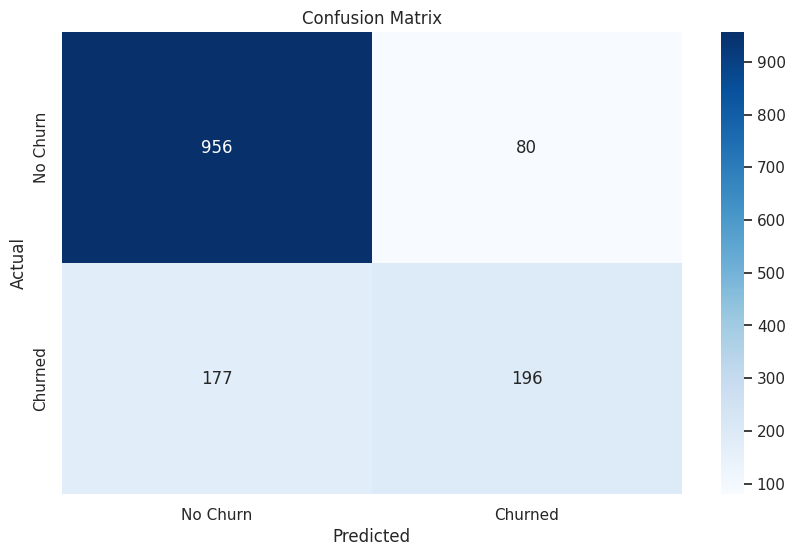

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report
import seaborn as sns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=1000,min_samples_split=10, max_depth=12, min_samples_leaf= 5, max_features= 0.3,random_state=42)
rf.fit(X_train, y_train)

# Predict & Evaluate
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

# Feature Importance
imp_df = pd.DataFrame({
    "feature": X.columns,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False).head(10)

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churned'], yticklabels=['No Churn', 'Churned'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Random Forest Implementation and Results

#### **Model Overview**
The Random Forest model was trained using the following hyperparameters:
- **`n_estimators=1000`**: A large number of trees ensures stable and reliable predictions.
- **`max_depth=12`**: Limits the depth of each tree to prevent overfitting while capturing sufficient complexity in the data.
- **`min_samples_split=10`** and **`min_samples_leaf=5`**: These parameters ensure meaningful splits and reduce overfitting.
- **`max_features=0.3`**: Limits the number of features considered for each split, improving generalization.

#### **Evaluation Metrics**
- **ROC AUC**: The model achieved a score of **0.88**, indicating strong discriminatory power in distinguishing between churned and non-churned customers.
- **Classification Report**:
  - For **non-churned customers (0)**: Precision = 0.84, Recall = 0.92, F1-score = 0.88.
  - For **churned customers (1)**: Precision = 0.71, Recall = 0.53, F1-score = 0.60.
  - Overall accuracy = **82%**.

In [ ]:
# Automating specific suggestions per customer

# Add churn probability to any database with columns in the format of merged_data
X = merged_data.drop('Churn', axis=1)
Y = rf.predict(X)
X["Churn_Probability (%)"] = Y

# Define suggestion function based on business rules
def suggest_offer(row):
    suggestions = []
    # if churn is less than 50% likely, no action necessary by assumption that it will be more costly than losing the customer
    if row.get("Churn_Probability (%)", 999) < 0.5:
        return "Low risk – no action needed"

    # if customers have a tenure shorter than 4 months
    if row.get("tenure", 999) < 4:
        # general followup required due to high risk of churning due to short tenure
        suggestions.append("Deploy a personal follow-up")
        # if the client has already complained
        if row.get("complaint_count", 0) >= 1:
            # offer some form of compensation
            suggestions.append("Offer onboarding perks or bill credits to ease early dissatisfaction")
            # and follow them to prevent further discomfort
        if row.get("complaint_count", 0) < 3:
            suggestions.append("Assign premium customer support")
    else:
        # if the customer is unsatisfied but has long tenure, reward their commitment
        suggestions.append("Provide cumulative discounts to reward commitment")

    # encourage long term contracts to enforce commitment and reduce frictions
    if row.get("Contract_One year", 1) == 0 and row.get("Contract_Two year", 1) == 0:
        suggestions.append("Offer advantageous longer-contract deals to encourage commitment")

    # if customer has high monthly spending, offer loyalty or multi-service discount to offset perceived costs
    if row.get("MonthlyCharges", 0) > 80:
        suggestions.append("Offer loyalty or multi-service discount")

    # if multiple complains have been received, deploy personalized support
    if row.get("complaint_count", 0) >= 3:
        suggestions.append("Assign premium customer support")

    # if not already doing so, incentivize paperless payments to reduce frictions
    if row.get("PaperlessBilling", 1) == 0:
        suggestions.append("Incentivize paperless billing")

    # if not already doing so, incentivize automatic credit card payments to reduce frictions
    if row.get("PaymentMethod_Credit card (automatic)", 1) == 0:
        suggestions.append("Advertise benefits of credit card payments - offer recharge deals when paying by card")

    # if multiple services are absent, offer a bundle to incentivize purchase
    if row.get("StreamingTV_No internet service", 0) == 1 and row.get("StreamingMovies_No internet service", 0) == 1:
        suggestions.append("Offer bundle or trial for online services")

    # if utilizing fiber optic, provide extra support to reduce dissatisfaction
    if row.get("InternetService_Fiber optic", 0) == 1:
        suggestions.append("Provide directed customer service for fiber optic specific problems")
        # if not already enrolled in tech support, offer a free trial of tech support
        if row.get("TechSupport", 1) == 0:
            suggestions.append("Offer a free trial of tech support")

    return "; ".join(suggestions) if suggestions else "General retention incentive"

# Apply suggestion logic
X["Suggested_Offer"] = X.apply(suggest_offer, axis=1)

# Altenerative Model Building (XGBoost)

In [ ]:
# Apply SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

from collections import Counter
print("Class distribution before SMOTE:", Counter(y_train))
print("Class distribution after SMOTE:", Counter(y_train_resampled))

Class distribution before SMOTE: Counter({0: 4138, 1: 1496})
Class distribution after SMOTE: Counter({0: 4138, 1: 4138})


**Reasoning**: Class imbalance can lead to biased models that favor the majority class. Using SMOTE ensures that the model learns equally from both classes, improving its ability to predict churned customers.

- **Train-Test Split**:
  - The dataset is split into training and testing sets using an 80-20 split.

- **Handling Class Imbalance with SMOTE**:
  - The `Churn` dataset is imbalanced, with significantly fewer churned customers compared to non-churned customers. To address this, **SMOTE (Synthetic Minority Oversampling Technique)** is applied to the training set.
  - SMOTE generates synthetic samples for the minority class (`Churn=1`) to balance the class distribution, improving the model's ability to predict churned customers.

- **Class Distribution Check**:
  - The class distribution is printed before and after applying SMOTE to verify that the imbalance has been addressed.

In [ ]:
# Model Training (XGBoost)

# Initialize the XGBoost classifier
xgb = XGBClassifier(random_state=42, eval_metric='logloss')

# Define hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='roc_auc', cv=3, verbose=1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_model = grid_search.best_estimator_
print("\nBest Parameters:", grid_search.best_params_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits

Best Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.8}


**Reasoning**: XGBoost is a state-of-the-art algorithm for classification tasks, and hyperparameter tuning ensures that the model is optimized for the dataset. Using GridSearchCV with cross-validation prevents overfitting and ensures that the model generalizes well to unseen data.

**Best Model Selection**: The best combination of hyperparameters is selected based on the grid search results, and the corresponding model is used for further evaluation.


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.87      1036
           1       0.64      0.62      0.63       373

    accuracy                           0.81      1409
   macro avg       0.75      0.75      0.75      1409
weighted avg       0.81      0.81      0.81      1409

ROC AUC: 0.8610


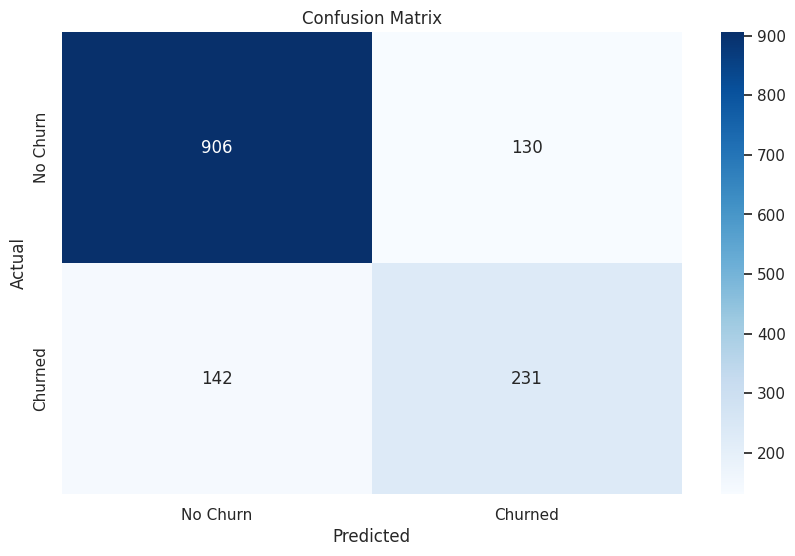

In [ ]:
# Model Evaluation

# Make predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC: {roc_auc:.4f}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churned'], yticklabels=['No Churn', 'Churned'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**Why Choose Random Forest over XGBoost?**
- **Higher ROC AUC**: Random Forest demonstrated better overall discriminatory power, which is critical for churn prediction.
- **Better Precision for Churned Customers**: Random Forest's higher precision for the churned class (0.71 vs. 0.64) means it is less likely to incorrectly classify non-churned customers as churned, reducing false alarms.
- **Interpretability**: Random Forest provides straightforward feature importance metrics, making it easier to interpret and explain the key drivers of churn to stakeholders.
- **Simplicity**: Random Forest requires less hyperparameter tuning compared to XGBoost, making it easier to implement and optimize.

# Model Save

In [ ]:
import joblib
# -----------------------------------------------
# 📌 1)  Get the exact feature order the model sees
# -----------------------------------------------
try:
    # scikit‑learn ≥ 1.0
    expected_features = rf.feature_names_in_.tolist()
except AttributeError:
    # older versions → fall back to the DataFrame you trained on
    expected_features = X.columns.tolist()

print("\n🔑 MODEL EXPECTS FEATURES IN THIS ORDER:\n")
for i, col in enumerate(expected_features, 1):
    print(f"{i:>2}. {col}")

# -----------------------------------------------
# 📌 2)  Persist the list so every component can load it
# -----------------------------------------------
import json, pathlib

MODEL_DIR = pathlib.Path("models")
MODEL_DIR.mkdir(exist_ok=True)

SCHEMA_PATH = MODEL_DIR / "churn_feature_schema.json"

with SCHEMA_PATH.open("w", encoding="utf‑8") as f:
    json.dump(expected_features, f, indent=2)

print(f"\n✅ Saved feature schema → {SCHEMA_PATH.resolve()}\n")

# Save model to a file




🔑 MODEL EXPECTS FEATURES IN THIS ORDER:

 1. gender
 2. SeniorCitizen
 3. Partner
 4. Dependents
 5. tenure
 6. PhoneService
 7. MultipleLines
 8. OnlineSecurity
 9. OnlineBackup
10. DeviceProtection
11. TechSupport
12. StreamingTV
13. StreamingMovies
14. PaperlessBilling
15. MonthlyCharges
16. TotalCharges
17. InternetService_Fiber optic
18. InternetService_No
19. Contract_One year
20. Contract_Two year
21. PaymentMethod_Credit card (automatic)
22. PaymentMethod_Electronic check
23. PaymentMethod_Mailed check
24. Poor Internet Speed
25. Poor Streaming Service Quality
26. Billing Issues
27. Payment Issues
28. Poor Customer Support
29. Poor Technical Support
30. Poor Phone Service Quality
31. Limited Device Protection
32. Online Security Issues
33. Contract Issues
34. Cancellation Issues
35. Limited Service Options
36. Customer Loyalty
37. High Monthly Charge
38. num_complaints

✅ Saved feature schema → /content/models/churn_feature_schema.json



In [ ]:
joblib.dump(rf, 'churn_model.pkl')

['churn_model.pkl']

In [ ]:
from google.colab import files

# Download the file
files.download('churn_model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Database Creation

In [ ]:
pip install Faker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from faker import Faker
import random

# 1) load the CSV you showed
df = pd.read_csv('CustomerData_Augmented.csv')

# 2) inject fake Italian names & phones
fake = Faker('it_IT')
n = len(df)
df.insert(1, 'name',    [fake.first_name()   for _ in range(n)])
df.insert(2, 'surname', [fake.last_name()    for _ in range(n)])
df.insert(3, 'phone',   [fake.phone_number().replace(' ', '') for _ in range(n)])
# 3) grab exactly the columns the RF knows about
feature_cols = list(rf.feature_names_in_)

# now build the full‑dataset feature matrix and score it
X_full = df[feature_cols]
proba   = rf.predict_proba(X_full)[:,1]
df['churn_risk_score'] = (proba * 100).round().astype(int)

# 4) bucket into risk_level
df['risk_level'] = np.select(
    [df['churn_risk_score'] > 60,
     (df['churn_risk_score'] >= 40) & (df['churn_risk_score'] <= 60)],
    ['high','moderate'],
    default='low'
)

# 5) random last_contacted in days (0–30)
df['last_contacted'] = np.random.randint(0,31,size=n)

# 6) collapse complaint theme flags into a list
theme_cols = [
    'Poor Internet Speed','Poor Streaming Service Quality',
    'Billing Issues','Payment Issues','Poor Customer Support',
    'Poor Technical Support','Poor Phone Service Quality',
    'Limited Device Protection','Online Security Issues',
    'Contract Issues','Cancellation Issues',
    'Limited Service Options','Customer Loyalty',
    'High Monthly Charge'
]

def make_list(row):
    return [tc for tc in theme_cols if row.get(tc,0)==1]

df['complaints'] = df.apply(make_list, axis=1)

# 7) reorder columns: ID, name, surname, phone, SeniorCitizen, Partner, Dependents, …, churn_risk_score, risk_level, last_contacted, complaints
fixed_front = ['customerID','name','surname','phone','gender','SeniorCitizen','Partner','Dependents','tenure','PhoneService','MultipleLines','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','PaperlessBilling','MonthlyCharges','TotalCharges','InternetService_Fiber optic','InternetService_No','Contract_One year','Contract_Two year','PaymentMethod_Credit card (automatic)','PaymentMethod_Electronic check','PaymentMethod_Mailed check','Churn']
fixed_back  = ['churn_risk_score','risk_level','last_contacted','complaints']

# drop any duplicates and then select in order
final_cols = [*fixed_front, 'num_complaints', *fixed_back]
customers_db = df.loc[:, final_cols]

# 8) save
customers_db.to_csv('customers_database.csv', index=False)
print("→ customers_database.csv written:", customers_db.shape)


→ customers_database.csv written: (7043, 33)
